In [2]:
from sklearn import decomposition
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy as sc
from random import randint, sample

from numba import jit

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import anderson_ksamp as anderson # test if samples are from the same distribution

from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%reload_ext autoreload
%autoreload 2
#%load_ext autoreload

import numpy as np
import pandas as pd
import scipy as sc

from tqdm import tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectFpr

In [3]:
Meta_Methyl = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/HumanMethylation450_meta.csv", sep=",", skiprows=7)
Meta_Methyl = Meta_Methyl[['IlmnID', 'Name', 'CHR', 'UCSC_RefGene_Name', 'UCSC_RefGene_Accession', 'UCSC_RefGene_Group', 'Regulatory_Feature_Group']]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
Methylation_scores = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/all_res_min01FC.csv", sep=";")
RNA_scores = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/sep_scores.csv", sep=";")

RNA_scores.set_index("Unnamed: 0", inplace=True)
Methylation_scores.set_index("Unnamed: 0", inplace=True)
Methylation_scores['LR_coeff']=(Methylation_scores.LR_coeff - Methylation_scores.LR_coeff.mean())/Methylation_scores.LR_coeff.std()

In [10]:
# add suffixes
RNA_scores.columns = [_col+"_RNA" for _col in RNA_scores.columns]
Methylation_scores.columns = [_col+"_Methylation" for _col in Methylation_scores.columns]

In [11]:
Merged = RNA_scores.copy().merge(Methylation_scores, how='left', left_on='Gene_RNA', right_on='Gene_Methylation')
Merged['score_WASS1_RNA_normalised']=(Merged.score_WASS1_RNA - Merged.score_WASS1_RNA.mean())/Merged.score_WASS1_RNA.std()
Merged['score_WASS1_Methylation_normalised']=(Merged.score_WASS1_Methylation - Merged.score_WASS1_Methylation.mean())/Merged.score_WASS1_Methylation.std()

In [13]:
Merged.columns

Index(['pvals_KW_RNA', 'score_KW_RNA', 'pvals_FDR_RNA', 'score_FDR_RNA',
       'pvals_KS_RNA', 'score_KS_RNA', 'pvals_MWU_RNA', 'score_MWU_RNA',
       'score_WASS1_RNA', 'score_WASS2_RNA', 'Gender_RNA', 'Chr_RNA',
       'Gene_RNA', 'Start_RNA', 'Stop_RNA', 'Strand_RNA', 'fc_split_RNA',
       'fold_change_abs_RNA', 'fold_change_rel_RNA', 'fold_change_median_RNA',
       'LR_coeff_normalised_RNA', 'LDA_score_normalised_RNA',
       'LR_coeff_Methylation', 'RF_importance_Methylation',
       'ET_importance_Methylation', 'XGB_importance_Methylation',
       'pvals_FDR_Methylation', 'score_FDR_Methylation',
       'pvals_KS_Methylation', 'score_KS_Methylation', 'pvals_MWU_Methylation',
       'score_MWU_Methylation', 'score_WASS1_Methylation',
       'abs_fc_Methylation', 'rel_fc_Methylation', 'abs_fc_median_Methylation',
       'Chr_Methylation', 'Start_Methylation', 'Stop_Methylation',
       'Strand_Methylation', 'Gene_Methylation',
       'Relation_CpG_Island_Methylation', 'score_WA

In [14]:
Merged['WASS1_prod'] = Merged['score_WASS1_RNA_normalised']*Merged['score_WASS1_Methylation_normalised']

Text(0, 0.5, 'Median RNA expression change')

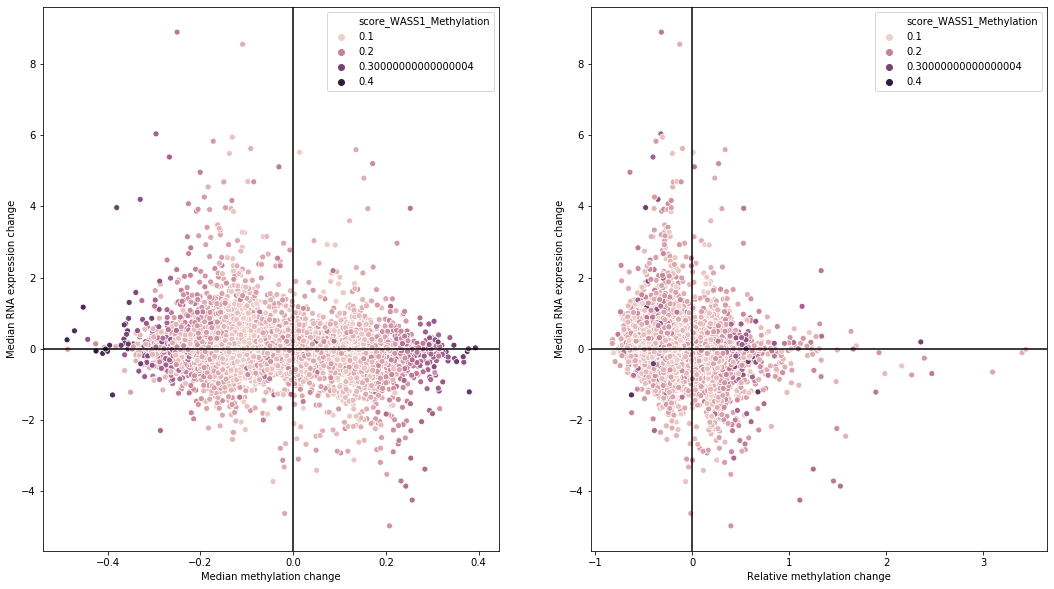

In [15]:
fig, ax = plt.subplots(figsize=(18,10), ncols=2)
agg=Merged[['Gene_RNA', 'fold_change_median_RNA', 'abs_fc_median_Methylation', 'rel_fc_Methylation', 'WASS1_prod',
            'score_FDR_RNA', 'score_KS_RNA', 'score_WASS1_Methylation', 'score_FDR_Methylation']].groupby(by='Gene_RNA').mean()
sns.scatterplot(data=agg, x='abs_fc_median_Methylation', y='fold_change_median_RNA', alpha=1, hue='score_WASS1_Methylation', ax=ax[0])
ax[0].axvline(0, color='black')
ax[0].axhline(0, color='black')
ax[0].set_xlabel('Median methylation change')
ax[0].set_ylabel('Median RNA expression change')

sns.scatterplot(data=agg, x='rel_fc_Methylation', y='fold_change_median_RNA', alpha=1, hue='score_WASS1_Methylation', ax=ax[1])
ax[1].axvline(0, color='black')
ax[1].axhline(0, color='black')
ax[1].set_xlabel('Relative methylation change')
ax[1].set_ylabel('Median RNA expression change')

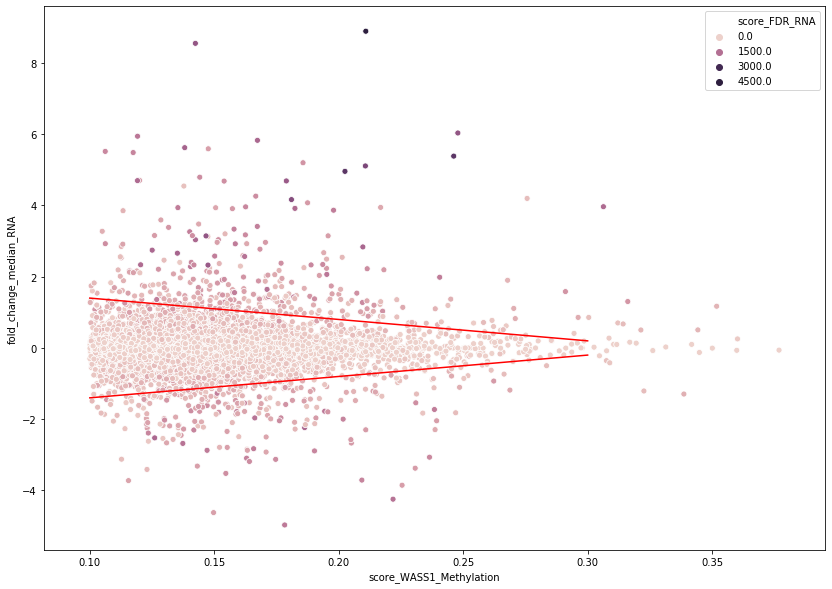

In [16]:
fig, ax = plt.subplots(figsize=(14,10))
agg=Merged[['Gene_RNA', 'fold_change_median_RNA', 'abs_fc_median_Methylation', 'WASS1_prod', 'score_FDR_RNA', 'fold_change_rel_RNA',
            'score_KS_RNA', 'score_KS_Methylation', 'score_WASS1_RNA', 'score_WASS1_Methylation']].groupby(by='Gene_RNA').mean()
sns.scatterplot(data=agg, x='score_WASS1_Methylation', y='fold_change_median_RNA', alpha=1, hue='score_FDR_RNA')
xd = np.linspace(0.1,0.3,20)
yd = 6*xd-2
plt.plot(xd, yd, '-r')

xd = np.linspace(0.1,0.3,20)
yd = -6*xd+2
plt.plot(xd, yd, '-r')

In [17]:
Merged['change_coeff_median'] = Merged.fold_change_median_RNA/(Merged.abs_fc_median_Methylation+0.01)
Merged['change_coeff_mean'] = Merged.fold_change_abs_RNA/(Merged.abs_fc_Methylation+0.01)

Text(0.5, 0, 'Delta RNA / Delta Methylation')

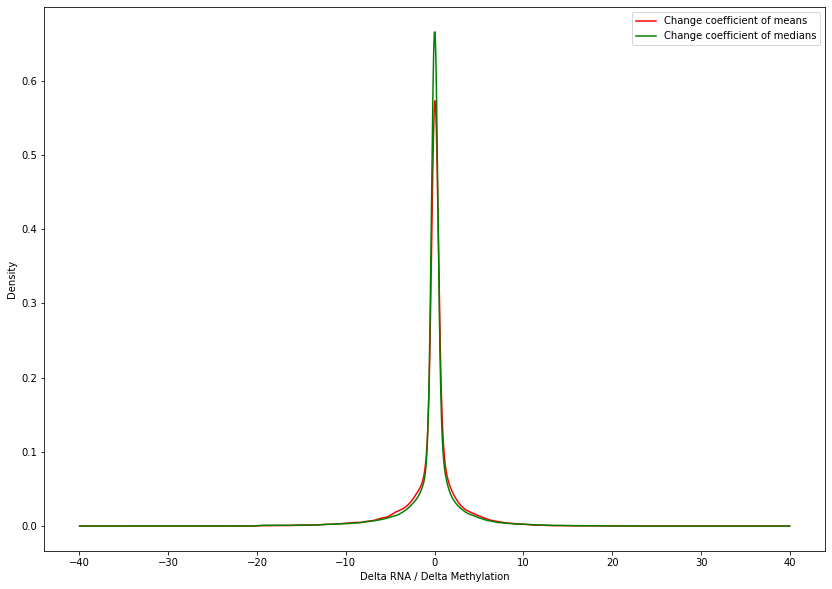

In [18]:
Merged.query('change_coeff_mean>-20').query('change_coeff_mean<20')['change_coeff_mean'].plot.kde(color='red', label='Change coefficient of means', figsize=(14,10))
Merged.query('change_coeff_median>-20').query('change_coeff_median<20')['change_coeff_median'].plot.kde(color='green', label='Change coefficient of medians')
plt.legend()
plt.xlabel('Delta RNA / Delta Methylation')

The relation between methylation and RNA expression is not clearly expressed in the current data. We would expect that the methylation change is negatively correlated with the change in RNA expression but both the negative and positive correlation occur equally for relative methylation fold changes above $0.1$.

It seems that the methylation only correlates significantly with a small number of gene expressions but in the bulk a **higher** methylation change corresponds
to a **smaller** absolute expression change. An easy explanation might be that higher methylation changes are associated with lower initial values of the RNA expression. 

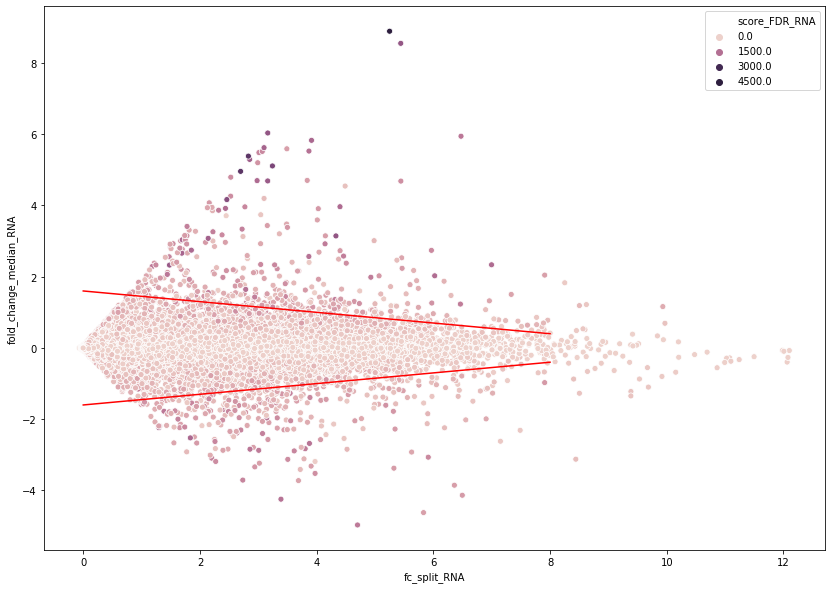

In [19]:
fig, ax = plt.subplots(figsize=(14,10))
agg=Merged[['Gene_RNA', 'fc_split_RNA', 'fold_change_median_RNA', 'abs_fc_median_Methylation', 'WASS1_prod', 'score_FDR_RNA', 'fold_change_rel_RNA',
            'score_KS_RNA', 'score_KS_Methylation', 'score_WASS1_RNA', 'score_WASS1_Methylation']].groupby(by='Gene_RNA').mean()
sns.scatterplot(data=agg.query('fold_change_rel_RNA<2500').query('fold_change_rel_RNA>-100'),
                y='fold_change_median_RNA', x='fc_split_RNA', alpha=1, hue='score_FDR_RNA')

xd = np.linspace(0,8,20)
yd = 0.15*xd-1.6
plt.plot(xd, yd, '-r')

xd = np.linspace(0,8,20)
yd = -0.15*xd+1.6
plt.plot(xd, yd, '-r')